# HSCT survival data exploration: survival analysis

## Notebook set-up

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dotenv import load_dotenv
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import configuration as config

# Load Kaggle login credentials from env
if Path(f'{config.PROJECT_ROOT_PATH}/.env').is_file():
    load_dotenv()

else:
    print(f'Put your Kaggle credentials in {config.PROJECT_ROOT_PATH}/.env')

# Create data directory if needed
Path(f'{config.DATA_PATH}/raw').mkdir(parents=True, exist_ok=True)

## 1. Data download

In [2]:
! kaggle competitions download -c equity-post-HCT-survival-predictions -p ../data/raw
! cd ../data/raw && unzip -n ./equity-post-HCT-survival-predictions.zip

equity-post-HCT-survival-predictions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./equity-post-HCT-survival-predictions.zip


## 2. Label distributions

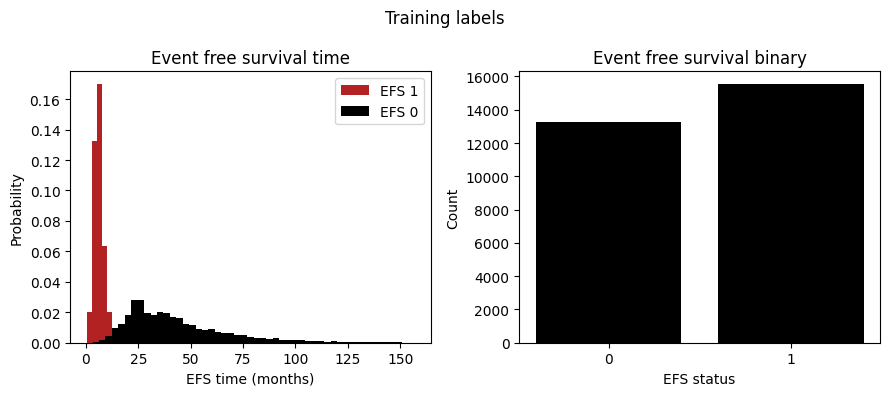

In [3]:
training_df=pd.read_csv(f'{config.DATA_PATH}/raw/train.csv')

efs_positive_df=training_df[training_df['efs'] == 1]
efs_negative_df=training_df[training_df['efs'] == 0]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Training labels')

axs[0].set_title('Event free survival time')
axs[0].hist(efs_positive_df['efs_time'], density=True, bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['efs_time'], density=True, bins=50, color='black', label='EFS 0')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Probability')
axs[0].legend(loc='best')

axs[1].set_title('Event free survival binary')
axs[1].bar(
    training_df['efs'].value_counts().index.values,
    training_df['efs'].value_counts(),
    tick_label=np.int32(training_df['efs'].value_counts().index.values),
    color='black'
)
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. Survival function

In [4]:
survival_function=sm.SurvfuncRight(training_df['efs_time'], training_df['efs'])
survival_function.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
0.333,0.999965,0.000035,28800,1.0
0.482,0.999931,0.000049,28799,1.0
0.523,0.999896,0.000060,28798,1.0
0.533,0.999861,0.000069,28797,1.0
0.543,0.999826,0.000078,28796,1.0


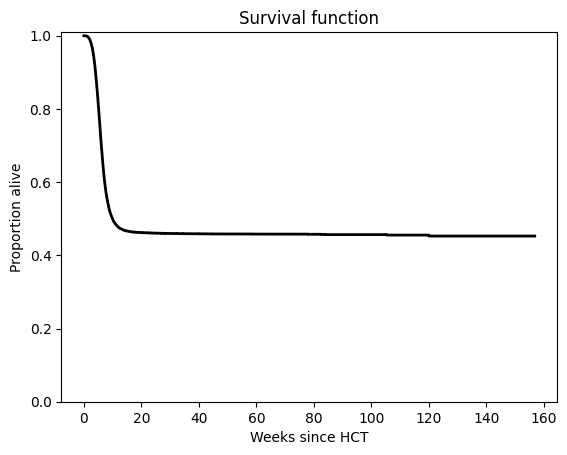

In [5]:
survival_plot=survival_function.plot()
ax=survival_plot.get_axes()[0]
li=ax.get_lines()
li[0].set_color('black')
li[1].set_visible(False)
ax.set_title('Survival function')
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Weeks since HCT')
plt.show()

## 4. Cumulative hazard: Nelson-Aalen estimate 

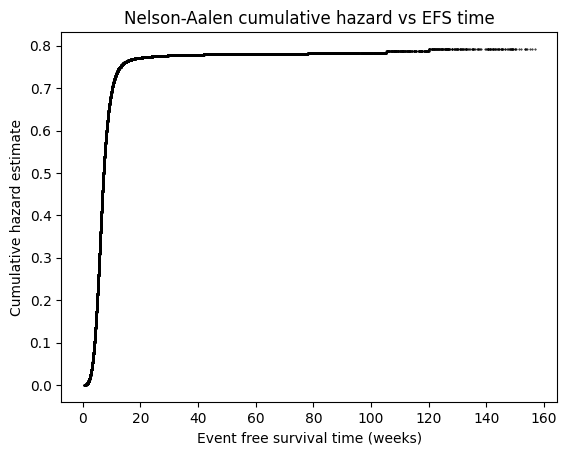

In [6]:
nelson_aalen=NelsonAalenFitter()

nelson_aalen.fit(
    durations=training_df['efs_time'],
    event_observed=training_df['efs']
)

training_df['na_cumulative_hazard']=nelson_aalen.cumulative_hazard_at_times(training_df['efs_time']).values

plt.title('Nelson-Aalen cumulative hazard vs EFS time')
plt.scatter(training_df['efs_time'], training_df['na_cumulative_hazard'], s=0.2, color='black')
plt.xlabel('Event free survival time (weeks)')
plt.ylabel('Cumulative hazard estimate')
plt.show()

## 5. Survival function: Kaplan-Meier estimate

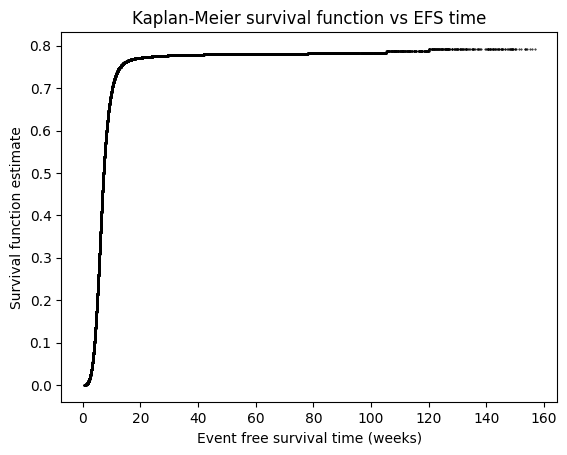

In [7]:
kaplan_meier=KaplanMeierFitter()

kaplan_meier.fit(
    durations=training_df['efs_time'],
    event_observed=training_df['efs']
)

training_df['km_survival_function']=kaplan_meier.cumulative_density_at_times(training_df['efs_time']).values

plt.title('Kaplan-Meier survival function vs EFS time')
plt.scatter(training_df['efs_time'], training_df['na_cumulative_hazard'], s=0.2, color='black')
plt.xlabel('Event free survival time (weeks)')
plt.ylabel('Survival function estimate')
plt.show()